In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-06-05 16:36:03 Configured OSMnx 1.1.2
2023-06-05 16:36:03 HTTP response caching is on


In [2]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

city = 'Guadalajara'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara


In [3]:
mun_gdf = mun_gdf.set_crs("EPSG:4326")

In [4]:
#Creates wkt for query
# It will be used to download the POI
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

<AxesSubplot: >

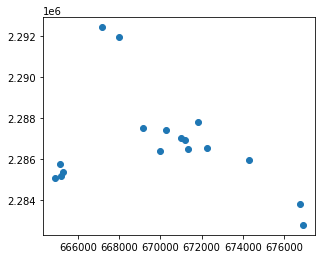

In [5]:
mibici = gpd.read_file('../../data/external/mibici/Estaciones filtradas.3.shp',
                         driver='ESRIShapefile')
mibici.plot()

In [6]:
import osmnx as ox

In [7]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx', edges_folder='edges_speed')

2023-06-05 16:39:16 Created graph from node/edge GeoDataFrames


## MiBici

In [8]:
mibici = mibici.to_crs("EPSG:4326")
mibici_osmid = aup.find_nearest(G, nodes,
                                mibici,
                                return_distance= True)
print(mibici_osmid.shape)
mibici_osmid.head(2)

(17, 14)


,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,geometry,osmid,distance_node
0,ZPN-060,None,None,None,None,None,-1,0,-1,None,None,POINT (-103.41456 20.65879),1387057490,10.899709
1,TLQ-012,None,None,None,None,None,-1,0,-1,None,None,POINT (-103.30190 20.63613),2240827916,22.870782


In [9]:
mibici_dist = aup.calculate_distance_nearest_poi(mibici_osmid, nodes, 
                edges, 'Name', 'osmid', wght='length')

In [10]:
mibici_dist

,x,y,street_count,geometry,dist_Name
osmid,,,,,
28751344,-103.306309,20.711533,3,POINT (-103.30631 20.71153),5952.797
28753224,-103.316645,20.700650,3,POINT (-103.31665 20.70065),4483.286
28757751,-103.307356,20.708526,3,POINT (-103.30736 20.70853),5601.185
28757777,-103.306806,20.710093,4,POINT (-103.30681 20.71009),5784.580
28768905,-103.305728,20.696546,3,POINT (-103.30573 20.69655),4506.190
...,...,...,...,...,...
9518278497,-103.411090,20.744225,4,POINT (-103.41109 20.74422),3228.910
9523272111,-103.543815,20.723294,3,POINT (-103.54382 20.72329),17219.479
9523319225,-103.188178,20.370875,3,POINT (-103.18818 20.37088),36071.599


## Preparatoria - Universidad

In [11]:
#Folder names from database
year = '2020'
denue_folder = 'denue_node_'+year

In [12]:
denue_dict = {'preparatoria':[611161,611162],
             'universidad':[611311,611312]}

### Preparatoria

In [13]:
a = 'preparatoria'
denue_codes = denue_dict[a]

In [14]:
denue_amenity = gpd.GeoDataFrame()
for cod in denue_codes:
    query = f"SELECT * FROM denue_nodes.{denue_folder} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = {cod})"
    denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))

/tmp/ipykernel_7571/3172918070.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))
/tmp/ipykernel_7571/3172918070.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))


In [15]:
nodes_distance_prep = aup.calculate_distance_nearest_poi(denue_amenity, nodes, 
                    edges, a, 'osmid', wght='length')

In [16]:
nodes_distance_prep.head(4)

,x,y,street_count,geometry,dist_preparatoria
osmid,,,,,
28751344,-103.306309,20.711533,3,POINT (-103.30631 20.71153),1790.454
28753224,-103.316645,20.700650,3,POINT (-103.31665 20.70065),1892.423
28757751,-103.307356,20.708526,3,POINT (-103.30736 20.70853),1639.895
28757777,-103.306806,20.710093,4,POINT (-103.30681 20.71009),1715.852


### Universidad

In [17]:
a = 'universidad'
denue_codes = denue_dict[a]

In [19]:
denue_amenity = gpd.GeoDataFrame()
for cod in denue_codes:
    query = f"SELECT * FROM denue_nodes.{denue_folder} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = {cod})"
    denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))

/tmp/ipykernel_7571/3172918070.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))
/tmp/ipykernel_7571/3172918070.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))


In [20]:
nodes_distance_univ = aup.calculate_distance_nearest_poi(denue_amenity, nodes, 
                    edges, a, 'osmid', wght='length')

In [21]:
nodes_distance_univ.head(4)

,x,y,street_count,geometry,dist_universidad
osmid,,,,,
28751344,-103.306309,20.711533,3,POINT (-103.30631 20.71153),1510.762
28753224,-103.316645,20.700650,3,POINT (-103.31665 20.70065),1275.182
28757751,-103.307356,20.708526,3,POINT (-103.30736 20.70853),1159.150
28757777,-103.306806,20.710093,4,POINT (-103.30681 20.71009),1342.545


## Isocronas

In [22]:
# read isochrone
iso_gdf = gpd.read_file('../../data/external/mibici/Estaciones_isocronas_600m.shp',
                         driver='ESRIShapefile')

In [23]:
#Creates wkt for query
# It will be used to download the POI
gdf_tmp = iso_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [24]:
#Folder names from database
schema = 'prox_analysis'
nodes_folder = 'nodes_proximity_2020'

In [25]:
query = f"SELECT * FROM {schema}.{nodes_folder} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(117562, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,1377285275,-103.388469,20.721292,POINT (-103.38847 20.72129),2.243440,sip_centro_admin,Guadalajara
1,1377285279,-103.388489,20.721189,POINT (-103.38849 20.72119),2.397326,sip_centro_admin,Guadalajara


In [26]:
nodes_geom = nodes[['osmid','geometry']].copy()
nodes_geom = nodes_geom.drop_duplicates()

In [27]:
nodes_analysis = nodes_geom.copy()

for amenidad in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})
    if nodes_tmp[amenidad].mean() == 0:
        nodes_tmp[amenidad] = -1
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
print(nodes_analysis.shape)
nodes_analysis.head(2)

(2734, 45)


,osmid,geometry,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,denue_dif,...,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sigade_preescolar,sigade_primaria,sigade_secundaria,denue_bares
0,1377285275,POINT (-103.38847 20.72129),2.243440,5.632175,2.877409,16.064677,3.226944,8.732384,7.27449,4.268442,...,51.725137,5.638754,5.233732,2.414498,15.962559,7.259482,1.923536,1.923536,2.877409,1.314776
1,1377285279,POINT (-103.38849 20.72119),2.397326,5.807525,2.702059,16.240027,3.051594,8.557034,7.44984,4.093092,...,51.549787,5.463404,5.265405,2.589848,16.113227,7.084132,1.748186,1.748186,2.702059,1.139426


In [28]:
nodes_analysis = nodes_analysis.set_index('osmid')
nodes_analysis = nodes_analysis.merge(nodes_distance_univ[['dist_universidad']], 
                                      left_index=True,
                                      right_index=True,
                                     how='left')

nodes_analysis = nodes_analysis.merge(nodes_distance_prep[['dist_preparatoria']], 
                                      left_index=True,
                                      right_index=True,
                                     how='left')
nodes_analysis.head(5)

,geometry,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,denue_dif,denue_biblioteca,...,sip_mercado,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sigade_preescolar,sigade_primaria,sigade_secundaria,denue_bares,dist_universidad,dist_preparatoria
osmid,,,,,,,,,,,,,,,,,,,,,
1377285275,POINT (-103.38847 20.72129),2.243440,5.632175,2.877409,16.064677,3.226944,8.732384,7.274490,4.268442,2.901787,...,5.233732,2.414498,15.962559,7.259482,1.923536,1.923536,2.877409,1.314776,182.569,170.175
1377285279,POINT (-103.38849 20.72119),2.397326,5.807525,2.702059,16.240027,3.051594,8.557034,7.449840,4.093092,2.726437,...,5.265405,2.589848,16.113227,7.084132,1.748186,1.748186,2.702059,1.139426,170.879,181.865
1377285288,POINT (-103.39031 20.72150),2.254081,5.461877,2.567065,19.272808,0.000000,11.608628,7.307006,1.041498,5.656743,...,2.213811,2.755329,13.061633,10.014438,3.841538,4.530788,0.000000,0.000000,180.098,372.960
1383977529,POINT (-103.39158 20.72173),4.311313,5.065047,4.632406,20.726592,1.008945,13.673969,8.599191,3.106839,7.722084,...,0.148470,1.420608,10.996292,12.079779,3.366111,3.366111,2.065341,0.148470,281.505,506.777
1383978563,POINT (-103.38937 20.72144),0.586275,4.131447,1.326521,17.721842,1.667806,10.368084,5.773762,2.709304,4.453274,...,3.576568,4.071662,14.433866,8.810969,3.559237,3.559237,1.326521,1.667806,265.558,265.575


<AxesSubplot: >

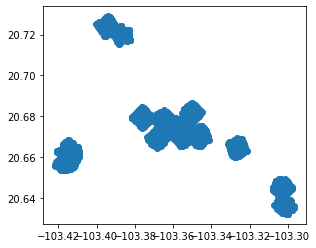

In [29]:
nodes_analysis.plot()

In [30]:
iso_gdf = iso_gdf.to_crs("EPSG:4326")
nodes_in_hex = gpd.sjoin(nodes_analysis, iso_gdf)
nodes_hex = nodes_in_hex.groupby([f'layer']).mean()
iso_time = pd.merge(iso_gdf,
                    nodes_hex,
                    left_on='layer',
                    right_index=True, how = 'outer')

# iso_time = iso_time.drop(['index_right','osmid'],axis=1)

iso_time.fillna(-1, inplace=True)

/tmp/ipykernel_7571/1603030059.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nodes_hex = nodes_in_hex.groupby([f'layer']).mean()


In [31]:
iso_time = iso_time.drop(columns=['id_x','cost_level_x','path',
                      'id_y','cost_level_y'])
iso_time.head(4)

,layer,geometry,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,denue_dif,...,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sigade_preescolar,sigade_primaria,sigade_secundaria,denue_bares,dist_universidad,dist_preparatoria,index_right
0,GDL-020,"POLYGON ((-103.36465 20.68360, -103.36455 20.6...",27.214228,3.869387,5.494990,20.243923,5.989191,10.586142,5.602498,4.490220,...,10.544718,5.205338,50.701395,4.160108,4.315969,5.616777,3.103782,286.119291,663.632377,0.0
1,GDL-084,"POLYGON ((-103.36861 20.67443, -103.36852 20.6...",40.796684,5.508308,15.797584,7.260632,4.092569,10.322990,4.410011,5.675243,...,4.062657,10.126849,66.697290,4.126344,6.108613,6.517075,2.228095,162.404292,708.837114,1.0
2,GDL-123,"POLYGON ((-103.37608 20.68484, -103.37598 20.6...",41.989806,5.332833,8.420990,20.656897,2.994842,11.428010,5.648109,9.313669,...,7.159377,4.429607,66.360970,3.347597,3.675979,3.926135,3.123271,163.535551,1122.491919,2.0
3,GDL-073,"POLYGON ((-103.35485 20.67481, -103.35475 20.6...",22.825414,3.053326,4.666652,13.118350,4.704976,8.212966,8.612631,7.326167,...,7.402308,4.488577,44.936500,3.836946,3.340894,4.268121,3.777028,211.291604,307.107008,3.0


In [32]:
iso_time['dist_universidad'] = (iso_time['dist_universidad'] * 60) / (4 * 1000) 

In [33]:
iso_time['dist_preparatoria'] = (iso_time['dist_preparatoria'] * 60) / (4 * 1000) 

In [38]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Gobierno':['sip_centro_admin'],
                                      'Guarderías':['denue_guarderias'],
                                      'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                   'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':1,
                        'Primaria':1,
                        'Secundaria':1},
            'Servicios comunitarios':{'Salud':1,
                                    'Gobierno':1,
                                    'Guarderías':1,
                                    'Asistencia social':1},
            'Comercio':{'Alimentos':1,
                        'Personal':1,
                        'Farmacias':1,
                        'Hogar':2,
                        'Complementarios':6},
            'Entretenimiento':{'Social':4,
                                'Actividad física':1,
                                'Cultural':1}
            }

In [39]:
# time by ammenity

column_max_ejes = [] # list with ejes index column names
column_max_all = [] # list with all max index column names

for e in idx_15_min.keys():
    
    column_max_ejes.append('max_'+ e.lower())
    column_max_all.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenity index column names
    
    for a in idx_15_min[e].keys():
        
        column_max_amenities.append('max_'+ a.lower())
        column_max_all.append('max_'+ a.lower())

        if wegiht_idx[e][a] < len(idx_15_min[e][a]):
            iso_time['max_'+ a.lower()] = iso_time[idx_15_min[e][a]].min(axis=1)

        else:
            iso_time['max_'+ a.lower()] = iso_time[idx_15_min[e][a]].max(axis=1)
        
    iso_time['max_'+ e.lower()] = iso_time[column_max_amenities].max(axis=1)

index_column = 'max_idx_15_min' # column name for 15 minute index data
column_max_all.append(index_column)
iso_time[index_column] = iso_time[column_max_ejes].max(axis=1)

<AxesSubplot: >

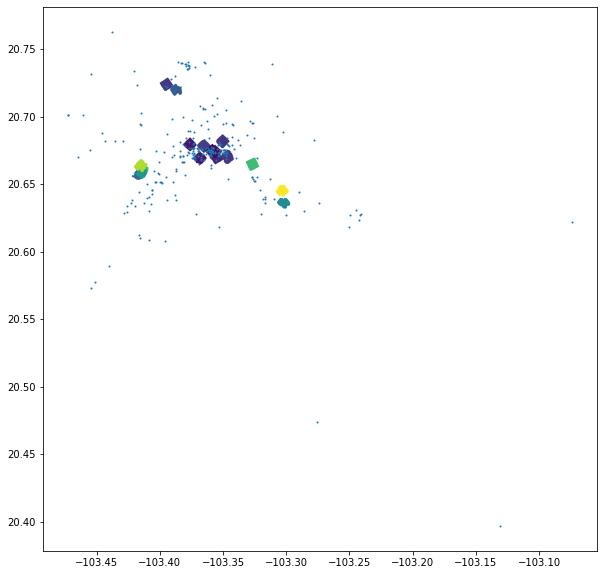

In [34]:
fix,ax = plt.subplots(figsize=(10,10))
iso_time.plot('dist_universidad',ax=ax)
denue_amenity.plot(markersize=1, ax=ax)

In [40]:
iso_time.head(5)

,layer,geometry,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,denue_dif,...,max_personal,max_farmacias,max_hogar,max_complementarios,max_comercio,max_social,max_actividad física,max_cultural,max_entretenimiento,max_idx_15_min
0,GDL-020,"POLYGON ((-103.36465 20.68360, -103.36455 20.6...",27.214228,3.869387,5.494990,20.243923,5.989191,10.586142,5.602498,4.490220,...,1.397741,3.001750,8.308293,5.164681,8.308293,3.103782,5.578156,11.849009,11.849009,27.214228
1,GDL-084,"POLYGON ((-103.36861 20.67443, -103.36852 20.6...",40.796684,5.508308,15.797584,7.260632,4.092569,10.322990,4.410011,5.675243,...,2.062518,3.734302,14.115399,7.528228,14.115399,2.228095,18.146980,4.715416,18.146980,40.796684
2,GDL-123,"POLYGON ((-103.37608 20.68484, -103.37598 20.6...",41.989806,5.332833,8.420990,20.656897,2.994842,11.428010,5.648109,9.313669,...,1.633668,2.470273,13.384062,9.052545,13.384062,3.123271,10.489815,9.172371,10.489815,41.989806
3,GDL-073,"POLYGON ((-103.35485 20.67481, -103.35475 20.6...",22.825414,3.053326,4.666652,13.118350,4.704976,8.212966,8.612631,7.326167,...,1.732019,4.521041,3.707983,8.719970,8.719970,3.777028,5.071455,7.310291,7.310291,22.825414
4,GDL-076,"POLYGON ((-103.34653 20.67563, -103.34644 20.6...",11.277242,8.671891,7.173339,9.119148,4.462658,15.293990,10.841111,4.382607,...,3.065476,4.055585,7.251538,6.352356,7.251538,2.491113,3.456876,7.825363,7.825363,11.277242


In [41]:
iso_time.to_file('../../data/external/mibici/Isocronas_Tiempos.geojson',
                         driver='GeoJSON')